# Federated PCA Demonstartion on 1000 Genomes Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path.insert(1, '/home/genxadmin/uk-biobank/src/preprocess')

import subprocess

import pandas as pd
import matplotlib.pyplot as plt

from preprocess.federated_pca import FederatedPCASimulationRunner

### [ 0 ] Create Data Folders

In [4]:
SPLIT_DIRECTORY = '/mnt/genx-bio-share/TG/data/chip/superpop_split'
federated_pca_runner = FederatedPCASimulationRunner(
    source_folder=f'{SPLIT_DIRECTORY}/genotypes',
    result_folder=f'{SPLIT_DIRECTORY}/federated_pca',
    variant_ids_file=f'{SPLIT_DIRECTORY}/genotypes/ALL.prune.in',
    n_components=20,
    method='P-STACK',
    nodes=['AFR', 'AMR', 'EAS', 'SAS', 'EUR']
)

# List of clients nodes
print(federated_pca_runner.nodes)

['AFR', 'AMR', 'EAS', 'SAS', 'EUR']


### [ 1 ] Variants Pruning (Simulation)

In [6]:
from preprocess.pruning import PlinkPruningRunner

PlinkPruningRunner(
    source_directory=f'{SPLIT_DIRECTORY}/genotypes',
    nodes=['AFR', 'AMR', 'EAS', 'SAS', 'EUR'],
    result_filepath=f'{SPLIT_DIRECTORY}/genotypes/ALL.prune.in',
    node_filename_template='%s_filtered'
).run(window_size=1000, step=50, threshold=0.001)

In [7]:
# variant_ids_file = federated_pca.VARIANT_IDS_FOLDER + '/pruned.ids'
variant_ids_file = f'{SPLIT_DIRECTORY}/genotypes/ALL.prune.in'

print('The number of ramaining variants')
!wc -l $variant_ids_file

The number of ramaining variants
5829 /mnt/genx-bio-share/TG/data/chip/superpop_split/genotypes/ALL.prune.in


### [ 2, 3, 4, 5 ] Using Federated PCA Simulation Runner

In [ ]:
federated_pca_runner.run()

### [ 2 ] Compute Allele Frequencies for ALL Data

Summarized allele frequencies are used by plink on each client node for better plink PCA results.

In [ ]:
federated_pca.compute_allele_frequencies(federated_pca.ALL, variant_ids_file=variant_ids_file)

### [ 3 ] Run Local PCA on Each Client

In [ ]:
allele_frequencies_file = federated_pca.PCA_FOLDER + '/ALL.acount'
for node in federated_pca.NODES:
    federated_pca.client(
        node=node,
        variant_ids_file=variant_ids_file,
        allele_frequencies_file=allele_frequencies_file
    )

### [ 4 ] Aggregate the Results on the Server to Compute the Joint PCA

In [12]:
evectors, evalues = federated_pca.server(federated_pca.NODES, n_components=2)
federated_pca.create_plink_eigenvec_allele_file(evectors, n_components=2)

### [ 5 ] Project the Client Feature Space onto Result Eigenvectors

In [ ]:
plink_allele_projector = federated_pca.PCA_FOLDER + '/federated.eigenvec.allele'
for node in federated_pca.NODES:
    federated_pca.client_projection(
        node=node,
        variant_ids_file=variant_ids_file,
        allele_frequencies_file=allele_frequencies_file,
        plink_allele_projector=plink_allele_projector,
        n_components=2
    )

### [ 6 ] Plot Projections Results for All Nodes

In [ ]:
colors = {
    'AFR': 'black',
    'SAS': 'blue',
    'EUR': 'red',
    'AMR': 'green',
    'EAS': 'grey'
}

for node in federated_pca_runner.nodes:
    evectors = pd.read_csv(f'{SPLIT_DIRECTORY}/federated_pca/{node}/fold_9_train_projections.csv.eigenvec.sscore', sep='\t')
    evectors = evectors.drop(evectors.columns[1:3], axis=1).rename(columns={'#IID': 'IID'}).set_index('IID')
    plt.scatter(evectors.iloc[:, [1]], evectors.iloc[:, [2]], c=colors[node])

plt.show()

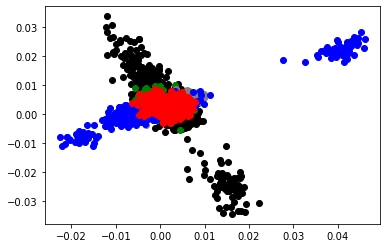

In [67]:
evectors = pd.read_csv(f'{SPLIT_DIRECTORY}/federated_pca/ALL/fold_3_train_projections.csv.eigenvec.sscore', sep='\t')
evectors = evectors.drop(evectors.columns[1:3], axis=1).rename(columns={'#IID': 'IID'}).set_index('IID')
samples = pd.read_csv('/mnt/genx-bio-share/TG/data/chip/igsr_samples.tsv', sep='\t', header=0)
codes = pd.merge(evectors, samples, left_on='IID', right_on='Sample name')['Superpopulation code'].to_numpy()

for node in federated_pca_runner.nodes:
    selector = (codes == node)
    plt.scatter(evectors.iloc[selector, [7]], evectors.iloc[selector, [8]], c=colors[node])

plt.show()

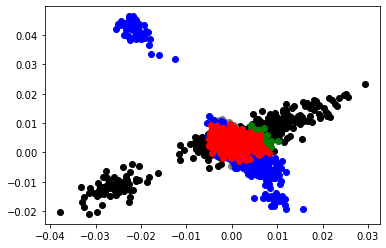

In [68]:
evectors = pd.read_csv(f'{SPLIT_DIRECTORY}/federated_pca/ALL/fold_9_train_projections.csv.eigenvec.sscore', sep='\t')
evectors = evectors.drop(evectors.columns[1:3], axis=1).rename(columns={'#IID': 'IID'}).set_index('IID')
samples = pd.read_csv('/mnt/genx-bio-share/TG/data/chip/igsr_samples.tsv', sep='\t', header=0)
codes = pd.merge(evectors, samples, left_on='IID', right_on='Sample name')['Superpopulation code'].to_numpy()

for node in federated_pca_runner.nodes:
    selector = (codes == node)
    plt.scatter(evectors.iloc[selector, [7]], evectors.iloc[selector, [8]], c=colors[node])

plt.show()

In [38]:
evectors.head()

,SCORE1_AVG,SCORE2_AVG,SCORE3_AVG,SCORE4_AVG,SCORE5_AVG,SCORE6_AVG,SCORE7_AVG,SCORE8_AVG,SCORE9_AVG,SCORE10_AVG,SCORE11_AVG,SCORE12_AVG,SCORE13_AVG,SCORE14_AVG,SCORE15_AVG,SCORE16_AVG,SCORE17_AVG,SCORE18_AVG,SCORE19_AVG,SCORE20_AVG
IID,,,,,,,,,,,,,,,,,,,,
HG00096,-0.001118,0.002058,-0.000419,0.000588,0.000072,-0.000134,-0.000026,0.000175,-0.000006,0.000212,0.000391,0.000174,0.000076,0.000074,-0.000094,0.000132,-0.000061,-0.000362,0.000073,-0.000160
HG00099,-0.001033,0.001955,-0.000482,0.000560,0.000013,-0.000085,0.000041,0.000086,-0.000077,0.000118,0.000150,-0.000613,-0.000085,-0.000347,0.000026,0.000376,-0.000115,-0.000338,0.000198,0.000140
HG00101,-0.001126,0.001841,-0.000379,0.000543,-0.000099,-0.000334,-0.000068,0.000057,-0.000298,-0.000349,-0.000071,-0.000149,-0.000172,-0.000179,-0.000068,0.000425,-0.000165,-0.000117,-0.000078,-0.000250
HG00102,-0.001310,0.001928,-0.000215,0.000692,-0.000151,0.000036,-0.000091,0.000052,-0.000207,-0.000081,-0.000052,0.000034,-0.000008,-0.000142,-0.000055,0.000023,-0.000184,-0.000130,-0.000320,-0.000180
HG00104,-0.001104,0.001982,-0.000263,0.000615,-0.000117,-0.000297,-0.000029,-0.000279,0.000172,0.000156,0.000226,-0.000337,-0.000081,0.000067,-0.000037,0.000325,0.000082,-0.000295,0.000298,-0.000136


### [ * ] Centralized PCA with Plink

In [ ]:
subprocess.run(['plink2',
    '--pfile', f'{SPLIT_DIRECTORY}/genotypes/ALL/fold_0_train',
    '--extract', f'{SPLIT_DIRECTORY}/genotypes/ALL.prune.in',
    '--freq', 'counts',
    '--out',  f'{SPLIT_DIRECTORY}/pca/ALL/fold_0_train_projections',
    '--pca', 'allele-wts', '20'
])

for part in ['train', 'val', 'test']:
    subprocess.run(['plink2',
        '--pfile', f'{SPLIT_DIRECTORY}/genotypes/ALL/fold_0_{part}',
        '--extract', f'{SPLIT_DIRECTORY}/genotypes/ALL.prune.in',
        '--read-freq', f'{SPLIT_DIRECTORY}/pca/ALL/fold_0_train_projections.acount',
        '--score', f'{SPLIT_DIRECTORY}/pca/ALL/fold_0_train_projections.eigenvec.allele',
            '2', '5', 'header-read', 'no-mean-imputation', 'variance-standardize',
        '--score-col-nums', '6-25',
        '--out', f'{SPLIT_DIRECTORY}/pca/ALL/fold_0_{part}_projections.csv.eigenvec'
    ])

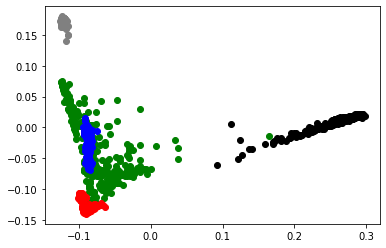

In [53]:
samples = pd.read_csv('/mnt/genx-bio-share/TG/data/chip/igsr_samples.tsv', sep='\t', header=0)

input_sscore_file = f'{SPLIT_DIRECTORY}/pca/ALL/fold_9_train_projections.csv.eigenvec.sscore'
sscore = pd.read_csv(input_sscore_file, sep='\t', header=0)
codes = pd.merge(sscore, samples, left_on='#IID', right_on='Sample name')['Superpopulation code'].to_numpy()

evectors = sscore[sscore.columns[3:]]
for node in federated_pca_runner.nodes:
    selector = (codes == node)
    plt.scatter(-evectors.iloc[selector, [0]], evectors.iloc[selector, [1]], c=colors[node])

### [ * ] All in Once

In [ ]:
import os
import time


n_components = 10
portions = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
ns_variants = []
elapsed_times = []
communication_costs = [] # FIXME: how to measure it?

for iteration, portion in enumerate(portions):
    print(f'MEASUREMENT {iteration + 1} OF {len(portions)}')

    federated_pca.prune(portion=portion)
    variant_ids_file = federated_pca.VARIANT_IDS_FOLDER + '/pruned.ids'
    n_variants = pd.read_csv(variant_ids_file, sep='\t', header=None).shape[0]
    ns_variants.append(n_variants)

    total_time = 0
    start = time.time()

    federated_pca.compute_allele_frequencies(federated_pca.ALL, variant_ids_file=variant_ids_file)
    allele_frequencies_file = federated_pca.PCA_FOLDER + '/ALL.acount'
    for node in federated_pca.NODES:
        federated_pca.client(
            node=node,
            variant_ids_file=variant_ids_file,
            allele_frequencies_file=allele_frequencies_file
        )

    evectors, evalues = federated_pca.server(federated_pca.NODES, n_components=n_components)
    federated_pca.create_plink_eigenvec_allele_file(evectors, n_components=n_components)

    plink_allele_projector = federated_pca.PCA_FOLDER + '/federated.eigenvec.allele'
    for node in federated_pca.NODES:
        federated_pca.client_projection(
            node=node,
            variant_ids_file=variant_ids_file,
            allele_frequencies_file=allele_frequencies_file,
            plink_allele_projector=plink_allele_projector,
            n_components=n_components
        )

    end = time.time()
    elapsed = end - start
    elapsed_times.append(elapsed)

    # Communication costs (Mb)
    cost = 0

    # [1] Alleles counts aggregation (approximation)
    acount_file = os.path.join(federated_pca.PCA_FOLDER, federated_pca.ALL + '.acount')
    cost += 6 * os.path.getsize(acount_file) / 1024 / 1024
    
    # [2] Local PCA results
    for node in federated_pca.NODES:
        eigenval_file = os.path.join(federated_pca.PCA_FOLDER, node + '.eigenval')
        eigenvec_allele_file = os.path.join(federated_pca.PCA_FOLDER, node + '.eigenvec.allele')

        cost += os.path.getsize(eigenval_file) / 1024 / 1024
        cost += os.path.getsize(eigenvec_allele_file) / 1024 / 1024

    # [3] Result PCA projection file to clients
    federated_eigenvec_allele_file = os.path.join(federated_pca.PCA_FOLDER, 'federated.eigenvec.allele')
    cost += os.path.getsize(federated_eigenvec_allele_file) / 1024 / 1024
    
    communication_costs.append(cost)

Text(0, 0.5, 'time [sec]')

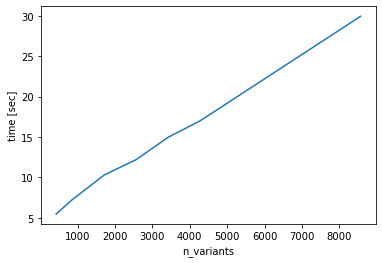

In [76]:
plt.plot(ns_variants, elapsed_times)
plt.xlabel('n_variants')
plt.ylabel('time [sec]')

Text(0, 0.5, 'communication_costs [Mb]')

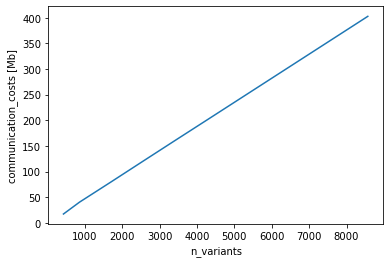

In [96]:
plt.plot(ns_variants, communication_costs)
plt.xlabel('n_variants')
plt.ylabel('communication_costs [Mb]')

### ...

In [52]:
import pandas as pd
import numpy as np

file = '/mnt/genx-bio-share/TG/data/chip/superpop_split/federated_pca/ALL/fold_9_train.eigenvec.allele'
fed = pd.read_csv(file, sep='\t', header=0)

np.linalg.norm(fed['PC1'])


272.95415966259134

In [50]:
np.linalg.norm(fed['PC11'])

273.2826886395811

In [51]:
file = '/mnt/genx-bio-share/TG/data/chip/superpop_split/pca/ALL/fold_9_train_projections.eigenvec.allele'
cnt = pd.read_csv(file, sep='\t', header=0)

np.linalg.norm(cnt['PC1'])

645.4761778655582